In [2]:
pip install faker


     ---------------------------------------- 1.8/1.8 MB 2.0 MB/s eta 0:00:00


In [28]:
# Importing required packages for analysis

import pandas as pd
import numpy as np
from faker import Faker
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Creating Fake data.
* The following code has been modified from previous to introduce missing values and duplicates in the data

In [35]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generate data
fake = Faker()
num_records = 1500

# Generate data with missing values
dates = [fake.date_between(start_date='-1y', end_date='today') for _ in range(num_records)]
times = [fake.time() for _ in range(num_records)]
customer_ids = [f'C{1000 + i}' for i in range(num_records)]
product_ids = [f'P{random.randint(1, 100)}' for _ in range(num_records)]

# Introduce missing values in 'Amount' field for 10% of the records
amounts = [np.random.uniform(50, 500) if random.random() > 0.1 else np.nan for _ in range(num_records)]

# Introduce missing values in 'Status' for 10% of the records
statuses = [np.random.choice(['Completed', 'Pending', 'Cancelled', 'Refunded', 'Chargeback']) if random.random() > 0.1 else np.nan for _ in range(num_records)]

# Introduce duplicates in 'Transaction_ID' for 5% of the records
transaction_ids = [f'TX{10000 + i}' for i in range(num_records)]
num_duplicates = int(num_records * 0.05)
for _ in range(num_duplicates):
    idx = random.randint(0, num_records - 1)
    transaction_ids[idx] = transaction_ids[random.randint(0, num_records - 1)]

# Generate remaining fields
payment_types = np.random.choice(['Credit Card', 'Debit Card', 'PayPal'], num_records)
countries = np.random.choice(['USA', 'UK', 'Canada', 'Australia'], num_records)
merchant_ids = [f'M{random.randint(1, 50)}' for _ in range(num_records)]

# Create DataFrame
df3 = pd.DataFrame({
    'Transaction_ID': transaction_ids,
    'Date': dates,
    'Time': times,
    'Customer_ID': customer_ids,
    'Product_ID': product_ids,
    'Amount': amounts,
    'Payment_Type': payment_types,
    'Country': countries,
    'Merchant_ID': merchant_ids,
    'Status': statuses
})

# Save to CSV
df3.to_csv('financial_transactions3.csv', index=False)

In [36]:
dataset=pd.DataFrame(df3)
print(dataset.shape)
dataset.head()

(1500, 10)


,Transaction_ID,Date,Time,Customer_ID,Product_ID,Amount,Payment_Type,Country,Merchant_ID,Status
0,TX10000,2023-11-04,08:23:52,C1000,P82,218.543053,PayPal,USA,M14,Refunded
1,TX10001,2024-03-11,06:35:36,C1001,P15,477.821438,Credit Card,Canada,M33,Pending
2,TX10002,2024-02-02,15:39:22,C1002,P4,379.397274,Debit Card,UK,M26,Chargeback
3,TX10003,2024-01-29,10:10:41,C1003,P95,319.396318,Debit Card,Canada,M22,Pending
4,TX10004,2024-03-07,02:58:07,C1004,P36,120.208388,Credit Card,UK,M36,Refunded


# Data Cleaning and preprocessing

In [37]:
#Check for null or missing values
dataset.isnull().sum()

Transaction_ID      0
Date                0
Time                0
Customer_ID         0
Product_ID          0
Amount            148
Payment_Type        0
Country             0
Merchant_ID         0
Status            143
dtype: int64

### Handling Missing Values:

* For categorical columns,ie. Status.I will fill missing values with the most common category.
* For numeric columns like 'Amount', I will fill missing values with the mean of the column grouped by Payment_type and country they fall under

In [38]:
# Fill missing values in categorical columns with the most common category
for col in ['Payment_Type', 'Country', 'Status']:
    most_common_category = dataset[col].mode()[0]
    dataset[col] = dataset[col].fillna(most_common_category)
    
# Step 1: Calculate mean amount per country and payment type
mean_amounts = dataset.groupby(['Country', 'Payment_Type'])['Amount'].mean()

# Step 2: Fill missing values in 'Amount' with the mean of amounts per country and payment type
for index, row in dataset.iterrows():
    if pd.isnull(row['Amount']):
        country = row['Country']
        payment_type = row['Payment_Type']
        mean_amount = mean_amounts.get((country, payment_type))
        if mean_amount is not None:  # Only fill if mean exists for the combination
            dataset.at[index, 'Amount'] = mean_amount

### Drop duplicates in the dataset

In [39]:
#Removing Duplicates
dataset1=dataset.drop_duplicates(subset='Transaction_ID',keep="first")
print(dataset.shape)
print(dataset1.shape)

(1500, 10)
(1430, 10)


In [40]:
# Check if dataset has an null values after processing
dataset1.isnull().sum()

Transaction_ID    0
Date              0
Time              0
Customer_ID       0
Product_ID        0
Amount            0
Payment_Type      0
Country           0
Merchant_ID       0
Status            0
dtype: int64

### Handling outliers

In [41]:
# We use Z-score method to detect outliers in 'Amount' column
from scipy.stats import zscore
z_scores = zscore(dataset1['Amount'])
outlier_indices = np.abs(z_scores) > 3  # Threshold for outlier detection
dataset1 = dataset1[~outlier_indices]

# After cleaning, let's reset the index
dataset1.reset_index(drop=True, inplace=True)
print(dataset1.shape)

(1430, 10)


No outliers were detected in the dataset hence dataframe remained the same.

### Converting data types

In [42]:
# Reviewing colum data types
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Transaction_ID  1430 non-null   object 
 1   Date            1430 non-null   object 
 2   Time            1430 non-null   object 
 3   Customer_ID     1430 non-null   object 
 4   Product_ID      1430 non-null   object 
 5   Amount          1430 non-null   float64
 6   Payment_Type    1430 non-null   object 
 7   Country         1430 non-null   object 
 8   Merchant_ID     1430 non-null   object 
 9   Status          1430 non-null   object 
dtypes: float64(1), object(9)
memory usage: 111.8+ KB


From output, we observe that the date column and time column has been parsed as strings. We can concatenate the date and tome column and convert todatetime

In [43]:
# Convert date from string to date
# Concatenate date and time to generate datetime

dataset1["Date"]=pd.to_datetime(dataset1["Date"])
dataset1['DateTime'] = pd.to_datetime(dataset1['Date'].astype(str) + ' ' + dataset1['Time'].astype(str))
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430 entries, 0 to 1429
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Transaction_ID  1430 non-null   object        
 1   Date            1430 non-null   datetime64[ns]
 2   Time            1430 non-null   object        
 3   Customer_ID     1430 non-null   object        
 4   Product_ID      1430 non-null   object        
 5   Amount          1430 non-null   float64       
 6   Payment_Type    1430 non-null   object        
 7   Country         1430 non-null   object        
 8   Merchant_ID     1430 non-null   object        
 9   Status          1430 non-null   object        
 10  DateTime        1430 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 123.0+ KB


# Exploratory Analysis

* We observe trends in transaction and transaction behaviour per month, day and time

### Monthly transactions Trend
1. We look at monthly transactions trend to identify whether there are periods when the number of transactions peaked

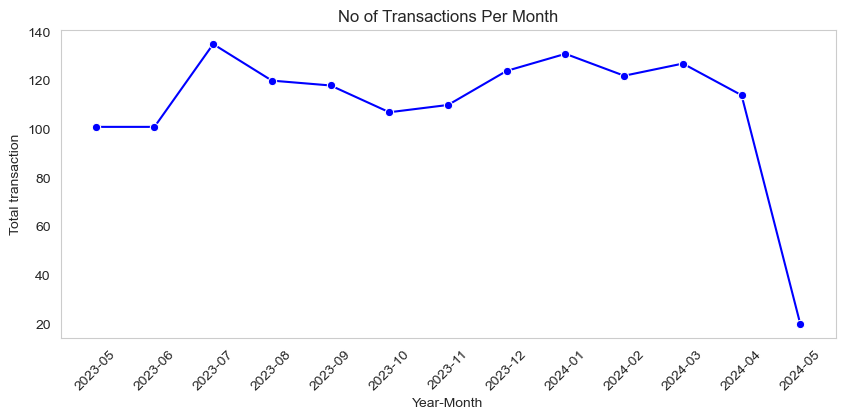

In [44]:
# Extract month and year
dataset1['Year_Month'] = dataset1['DateTime'].dt.strftime("%Y-%m")

# Group by 'Year_Month' and unique count of transactions'
monthly_trend_count = dataset1.groupby('Year_Month')['Transaction_ID'].nunique().reset_index()
# Sort by 'Year_Month' in ascending order
monthly_trend_counts = monthly_trend_count.sort_values(by="Year_Month",ascending=True)

# Plotting trend analysis
plt.figure(figsize=(10, 4))
sns.lineplot(x='Year_Month', y='Transaction_ID', data=monthly_trend_counts, marker='o',color="blue")
plt.title('No of Transactions Per Month')
plt.xlabel('Year-Month')
plt.ylabel('Total transaction')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

##### Outome
1. The number of transactions seemed to have been highest in the month of July compared to other months. Given the data is only limited to one year, we are not able to determine whether this is a repetitive trend.

### Frequency of Transactions by day of the month
1. We look at days transactions trend to identify whether there are days in which the number of transactions peak

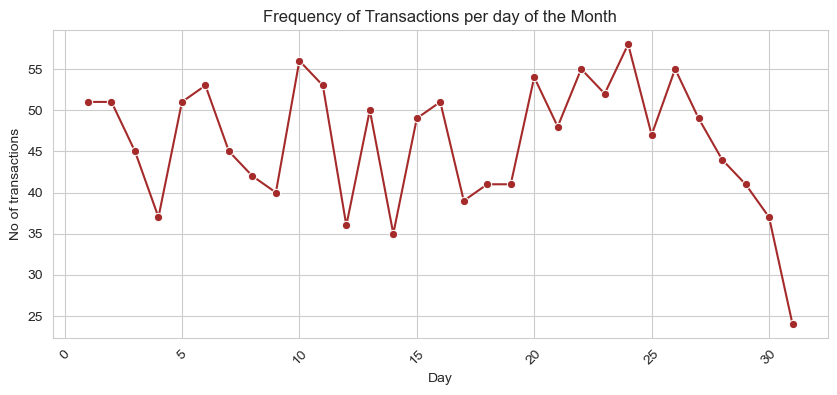

In [45]:
# Extract days from date column
dataset1["Day"]=dataset1["Date"].dt.day
# Group by 'day' and count number of transaction'
daily_trend_count = dataset1.groupby('Day')['Transaction_ID'].nunique().reset_index()
# Sort by 'day' in ascending order
daily_trend_counts = daily_trend_count.sort_values(by="Day",ascending=True)

# Plotting trend analysis
plt.figure(figsize=(10, 4))
sns.lineplot(x='Day', y='Transaction_ID', data=daily_trend_counts, marker='o',color="brown")
plt.title('Frequency of Transactions per day of the Month')
plt.xlabel('Day')
plt.ylabel('No of transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

* The trend analysis shows there appears to be certai days in the month where the frequency of transactions is much higher. The transactions peak towards end of the month on 24th day of the month.

### Weekday Transactions trend

* We perform a trend analysis to show whether there are specific weekdays which seem to have high number of transactions compared to other days

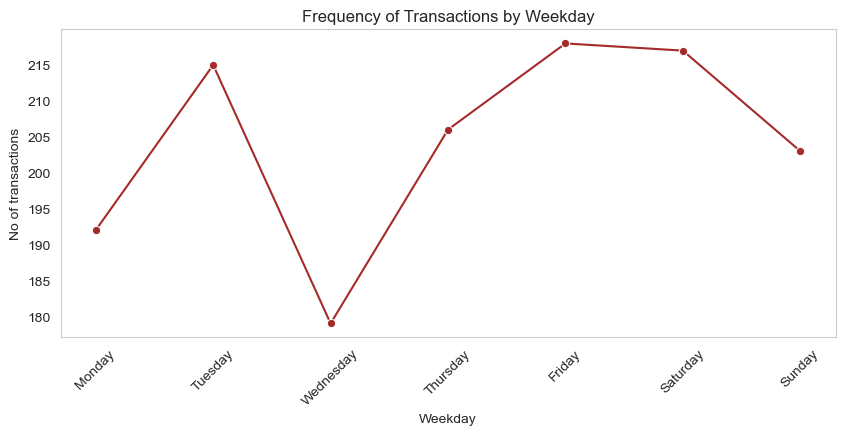

In [46]:
dataset1["Weekday"]=dataset1["Date"].dt.weekday
transactions_by_weekday = dataset1.groupby('Weekday')['Transaction_ID'].nunique().reset_index()
# Sort by 'Year_Month' in ascending order

# Define the natural order of weekdays (Monday to Sunday)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Sort the DataFrame by 'Weekday' in ascending order
transactions_by_weekday_order = transactions_by_weekday.sort_values(by='Weekday',ascending=True)

# Map the numeric weekday to their corresponding names
transactions_by_weekday_order['Weekdayname'] = transactions_by_weekday['Weekday'].map({i: day for i, day in enumerate(weekday_order)})


# Plotting trend analysis
plt.figure(figsize=(10, 4))
sns.lineplot(x='Weekdayname', y='Transaction_ID', data=transactions_by_weekday_order, marker='o',color="brown")
plt.title('Frequency of Transactions by Weekday')
plt.xlabel('Weekday')
plt.ylabel('No of transactions')
plt.xticks(rotation=45)
plt.grid(False)
plt.show()

* From trend analysis majority of the transactions happen on Fridays and Saturdays

#### Transaction frequency by Time
The Analysis shows at what time majority of the transactions occur

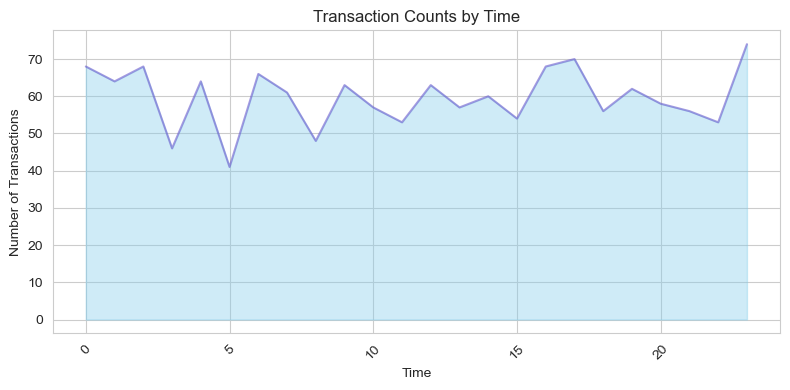

,hour,Transaction_Count
0,0,68
1,1,64
2,2,68
3,3,46
4,4,64
5,5,41
6,6,66
7,7,61
8,8,48
9,9,63


In [47]:
# Extract time from 'DateTime' column
dataset1['hour'] = dataset1['DateTime'].dt.hour

# Group by 'Time' and count the number of transactions for each time
transaction_counts_by_time = dataset1.groupby('hour').size().reset_index(name='Transaction_Count')

# # Plotting
plt.figure(figsize=(8, 4))
plt.fill_between(transaction_counts_by_time['hour'], transaction_counts_by_time['Transaction_Count'], color='skyblue', alpha=0.4)
plt.plot(transaction_counts_by_time['hour'], transaction_counts_by_time['Transaction_Count'], color='Slateblue', alpha=0.6)
plt.title('Transaction Counts by Time')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
transaction_counts_by_time

### Analysis of transactions by various categorical Variables

* An analysis by the number of transactions per payment type shows that Credit card is the most frequently used form of transaction, followed by paypal and then Debit card
* In terms of Amount, credit card payments amounts were slightly higher that other payment channels at 34% comapared to debit card and paypal's 32% each.
* Boxplot Analysis shows that the distribution of amounts paid using the different payment type is similar, i.e 75% of the transactions were above 180.

In [48]:
#Most used payment type

# Grouping by 'payment type' and counting unique Transactions
payment_counts=dataset1.groupby("Payment_Type")["Transaction_ID"].nunique().reset_index()

# Calculating percentages
payment_counts['%ge']=(payment_counts["Transaction_ID"]/payment_counts["Transaction_ID"].sum())*100
payment_counts

,Payment_Type,Transaction_ID,%ge
0,Credit Card,504,35.244755
1,Debit Card,458,32.027972
2,PayPal,468,32.727273


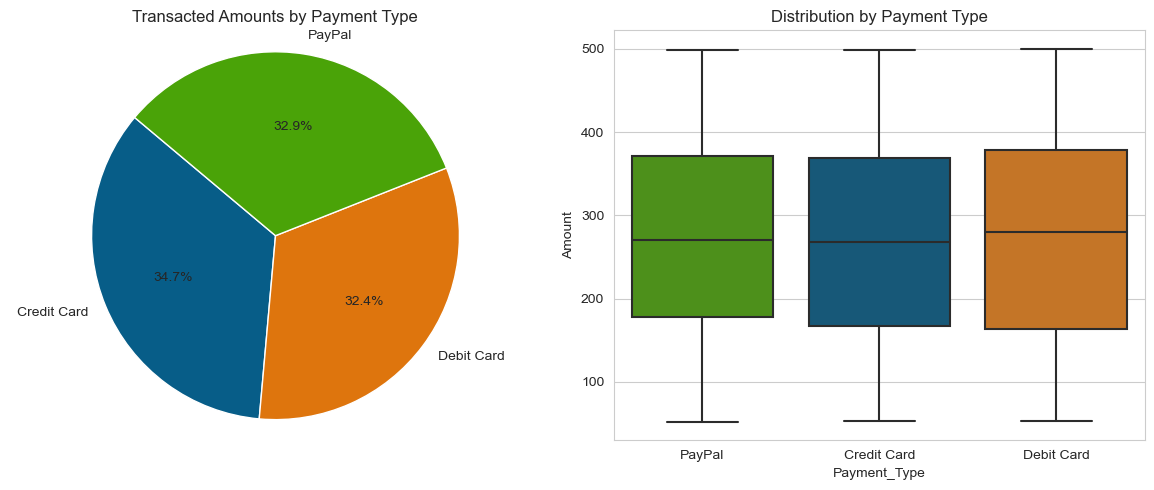

In [49]:
category_colors = {'PayPal': '#4AA308', 'Credit Card': '#075D88', 'Debit Card': '#DE750D'}
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.set_style("whitegrid")
sns.set_palette(category_colors.values())
Amounts = dataset1.groupby('Payment_Type')['Amount'].sum()
axes[0].pie(Amounts, labels=Amounts.index,\
            colors=[category_colors[c] for c in Amounts.index],autopct='%1.1f%%', startangle=140)
axes[0].set_title('Transacted Amounts by Payment Type')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Plotting boxplot
sns.boxplot(x='Payment_Type', y='Amount', data=dataset1, palette=category_colors,ax=axes[1])
axes[1].set_title('Distribution by Payment Type')

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

Text(0.5, 1.0, 'Payment Type Distribution By Count')

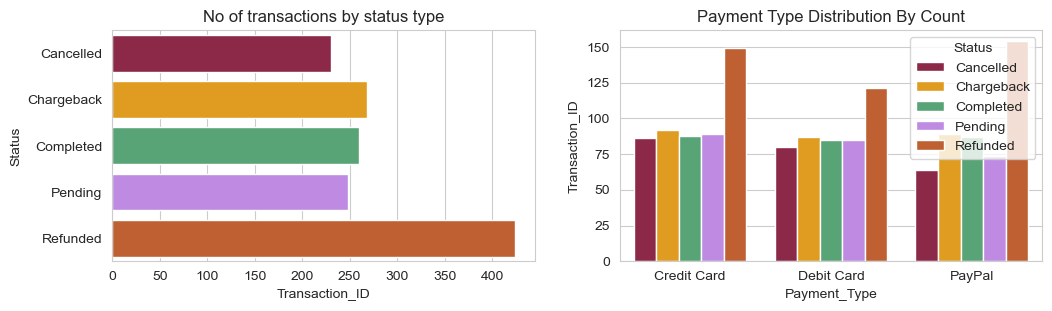

In [88]:
plt.figure(figsize=(12,3))
colors = {'Cancelled': '#9D1941', 'Chargeback': 'orange', 'Completed': '#4DB075','Pending': '#C17BF1','Refunded': '#D6571C'}


plt.subplot(1, 2, 1)

Transaction_by_status=dataset1.groupby(["Status"])["Transaction_ID"].nunique().reset_index()
sns.barplot(x="Transaction_ID",y="Status",data=Transaction_by_status,palette=colors)
plt.title("No of transactions by status type")

plt.subplot(1, 2, 2)

Status_by_payment_type=dataset1.groupby(["Status","Payment_Type"])["Transaction_ID"].nunique().reset_index()
sns.barplot(data=Status_by_payment_type,x="Payment_Type",y="Transaction_ID", hue="Status", palette=colors)
plt.title("Payment Type Distribution By Count")       

Text(0.5, 1.0, 'Payment Type Distribution By Count')

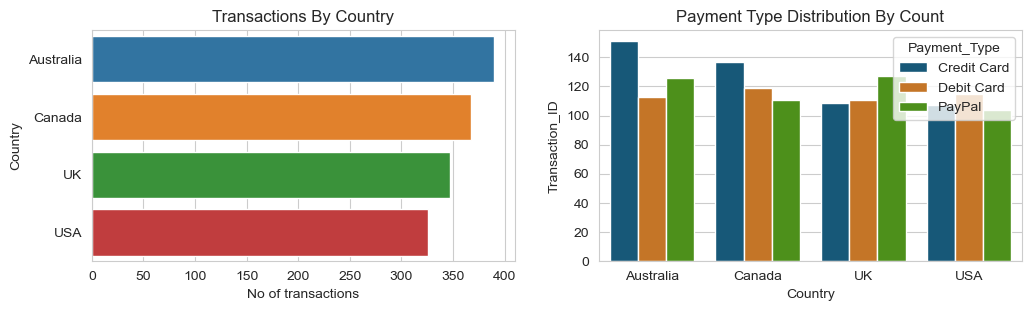

In [53]:
# No of transactions by country
# Plotting bar chart
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
category_counts=dataset1["Country"].value_counts().sort_values(ascending=False).index
sns.countplot(y="Country", data=dataset1,order=category_counts, palette="tab10")
plt.title('Transactions By Country')
plt.xlabel('No of transactions')

plt.subplot(1, 2, 2)

Transaction_by_country=dataset1.groupby(["Country","Payment_Type"])["Transaction_ID"].nunique().reset_index()
sns.barplot(data=Transaction_by_country,x="Country",y="Transaction_ID", hue="Payment_Type", palette=category_colors)
plt.title("Payment Type Distribution By Count")     

Text(0.5, 1.0, 'No Of customers By Country')

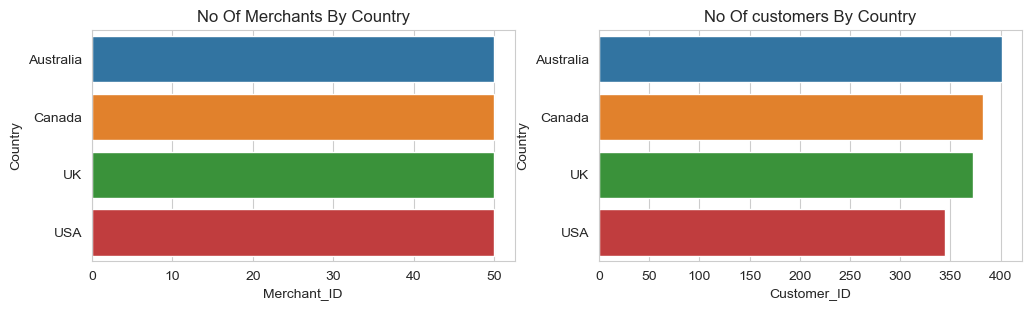

In [54]:
# Why Australia has highest number of transactions

#No of merchants per country

plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
Merchants_by_country=dataset.groupby(["Country"])["Merchant_ID"].nunique().reset_index()
sns.barplot(x="Merchant_ID",y="Country",data=Merchants_by_country,palette="tab10")
plt.title("No Of Merchants By Country")

#No of customers per country
plt.subplot(1, 2, 2)
customers_by_country=dataset.groupby(["Country"])["Customer_ID"].nunique().reset_index()
sns.barplot(x="Customer_ID",y="Country",data=customers_by_country,palette="tab10")
plt.title("No Of customers By Country")

#### Fraudulent Patterns
* Unusual Time of Transactions: Transactions occurring at unusual times, such as late at night or early in the morning, may be indicative of fraudulent behavior.
* High Frequency of transactions within a short period from the same customer
* Unusual Purchase Patterns: Patterns such as purchasing high-value items followed by refunds
* Unusual Transaction Amounts: Transactions significantly deviating from the typical range of transaction amounts for a given customer or merchant may indicate fraudulent behavior.

From the analysis, Majority of the transactions that occured between 12:00 am and 3:59 am were refunds, which could be an indication of Fraudulent activities

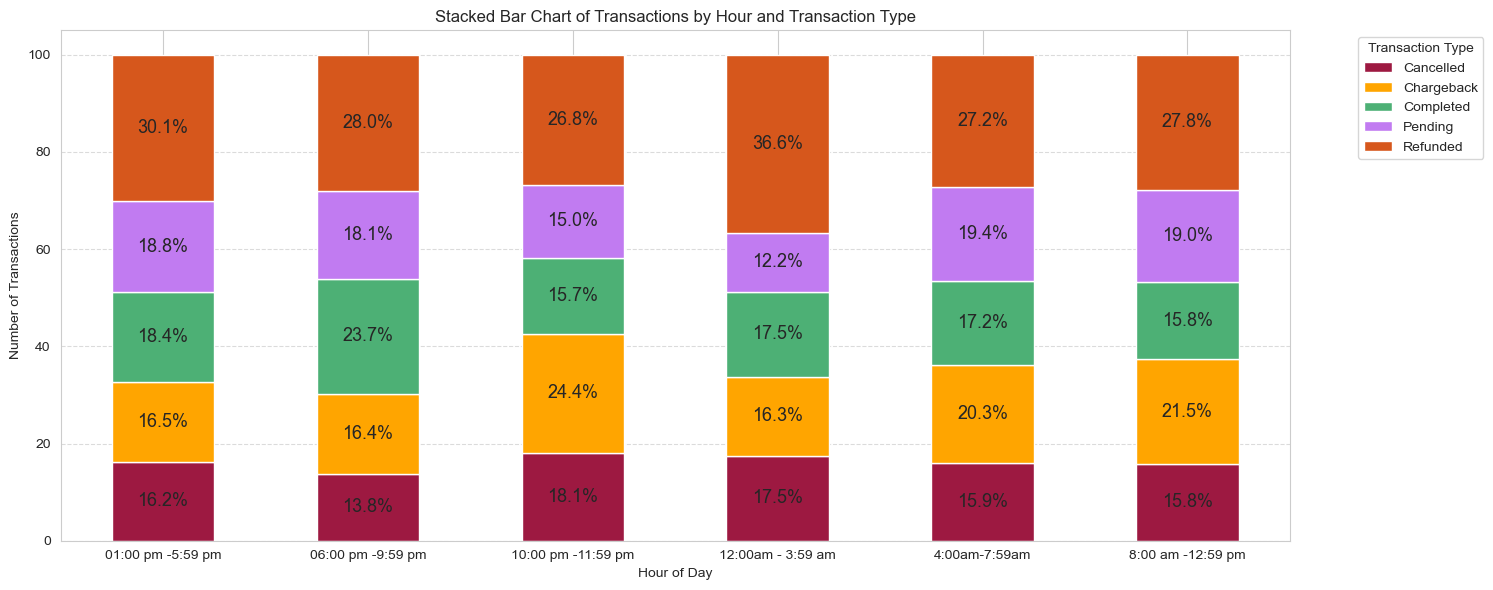

In [127]:
# time groups
dataset1["time_group"]=dataset1['hour'].apply(lambda x: "12:00am - 3:59 am" if x<=3 else\
                                              ("4:00am-7:59am" if 3<x<=7 else\
                                               ('8:00 am -12:59 pm' if 8<=x<=12 else\
                                                ('01:00 pm -5:59 pm' if 13<=x<=17 else\
                                                 ('06:00 pm -9:59 pm' if 18<=x<=21 else\
                                                  ('10:00 pm -11:59 pm' if 22<=x<=23 else
                                                 "unknown" ))))))


# Group by hour and Status, and count the number of transactions
transactions_by_hour_and_status = dataset1.groupby(['time_group','Status']).size().unstack().fillna(0)
time_order=['12:00am - 3:59am','4:00am-7:59am','8:00am -12:59pm','01:00pm -5:59pm',\
            '06:00pm -9:59pm','10:00pm -11:59pm']

# Create a dictionary to map values to their sorting order
sort_order = {name: i for i, name in enumerate(time_order)}

# Sort the DataFrame based on the specified order
transactions_by_hour_and_status1 = transactions_by_hour_and_status.sort_values(by='time_group', key=lambda x: x.map(sort_order))
# Calculate percentage contribution
transaction_perc = transactions_by_hour_and_status1.div(transactions_by_hour_and_status.sum(axis=1), axis=0) * 100

# Plotting
plt.rcParams['figure.figsize'] = [15, 6]

ax = transaction_perc.plot(kind='bar', stacked=True, color=colors)
plt.title('Stacked Bar Chart of Transactions by Hour and Transaction Type')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=13)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

* Fraudulent transactions are mostly high value transactions accompanied by refunds. In the below analysis we will evaluate high transaction amounts falling in the upper >95% quartile and analyze the type of transactions made as well as by the payment type 

In [130]:
# Show transaction types with amounts greater than 95% of the data.
suspicious_transactions = dataset1[dataset1['Amount'] > dataset1['Amount'].quantile(0.95)]
print(suspicious_transactions.shape)

(72, 16)


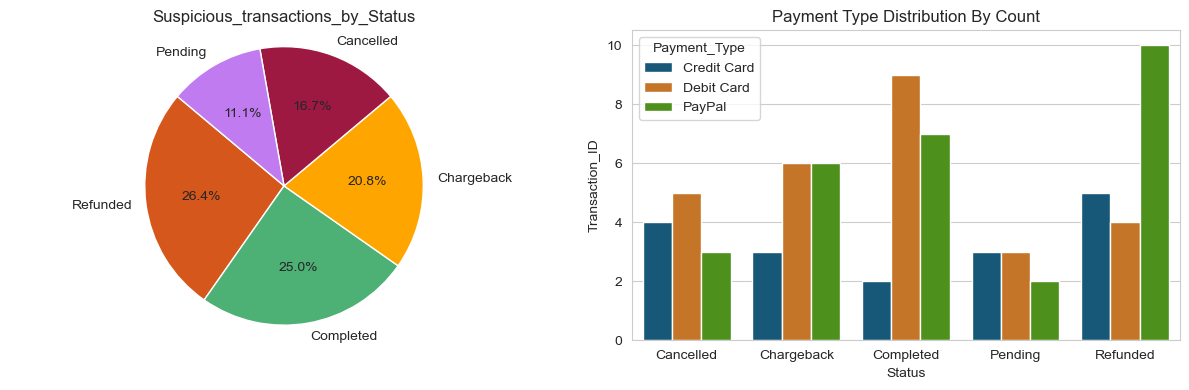

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.set_style("whitegrid")
sns.set_palette(colors.values())
status_counts=suspicious_transactions["Status"].value_counts()
axes[0].pie(status_counts, labels=status_counts.index,\
            colors=[colors[c] for c in status_counts.index],autopct='%1.1f%%', startangle=140)
axes[0].set_title('Suspicious_transactions_by_Status')
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

suspicious_transactions_by_paymenttype=suspicious_transactions.groupby(["Status","Payment_Type"])["Transaction_ID"].nunique().reset_index()
sns.barplot(data=suspicious_transactions_by_paymenttype,x="Status",y="Transaction_ID", hue="Payment_Type",\
            palette=category_colors,ax=axes[1])
axes[1].set_title("Payment Type Distribution By Count")

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()

* From Analysis we observe that highest number of transactions are refunds which constitute 26% of total transactions
* Analysis also shows a majority of the transactions that had refunds were from paypal

In [157]:
# Create a new column with count of transactions per merchant within the same hour.

dataset1["merchnat_transactions_per_hour"]=dataset1.groupby(['Merchant_ID','hour'])['Transaction_ID'].transform('count')
dataset1["merchnat_transactions_per_hour"].value_counts()

2    530
1    439
3    273
4    148
5     40
Name: merchnat_transactions_per_hour, dtype: int64

# Predictive modelling

Predictive Modeling:
* Build a model to predict the likelihood of a transaction being fraudulent.
* Evaluate the model's performance using appropriate metrics (accuracy, precision,recall, F1-score, ROC-AUC)

- To build a predictive model, we would require a labeled dataset of fraudulent activities so as to train a supervised machine learning model to predict accuracy of fraud detection.
- I will create a generated column called "fraudulent activity" that asigns categorical variable 1 if transaction amount is above a certain threshold,if transaction time is within 12:00am-3:59am and status is refunded or chargeback and 0 if neither conditions are satisfied.

In [159]:
# Set threshold for identifying unusually high amounts
amount_threshold = dataset1['Amount'].quantile(0.95)

# Define conditions for fraudulent activity
def is_fraudulent(row):
    if ((row['Amount'] > amount_threshold)  \
    and (row['Status'] in ['Refunded', 'Chargeback']) and (row['time_group'] == "12:00am - 3:59 am")) |\
    ((row['time_group'] == "12:00am - 3:59 am") and row['Payment_Type'] == "PayPal") |\
    (row['merchnat_transactions_per_hour'] >4) :
        return 1
    else:
        return 0

# Apply the function to create the new column
dataset1['fraudulent_activity'] = dataset1.apply(is_fraudulent, axis=1)

# Display the updated DataFrame
dataset1['fraudulent_activity'].value_counts()

0    1313
1     117
Name: fraudulent_activity, dtype: int64

### Datapreprocessing

To prepare data for machine learning model, we will perform the following steps:

* i) Feature engineering and feature selection
* ii) Data preprocessing: label encoding or one-hot encoding of categorical variables 
* iii) Upsampling or resampling data if data is heavily imbalance

In [198]:
# Selecting relevant features for the training

dataset_modeling=dataset1[['Amount','Payment_Type', 'Country',\
                           'Day', 'hour', 'merchnat_transactions_per_hour','fraudulent_activity']]
dataset_modeling.head()

,Amount,Payment_Type,Country,Day,hour,merchnat_transactions_per_hour,fraudulent_activity
0,218.543053,PayPal,USA,4,8,1,0
1,477.821438,Credit Card,Canada,11,6,4,0
2,379.397274,Debit Card,UK,2,15,1,0
3,319.396318,Debit Card,Canada,29,10,2,0
4,120.208388,Credit Card,UK,7,2,3,0


### Encoding Categorical data
* Since above dataset has no categories values that are oridinal, we will instead perform one hot encoding to all categorical variables

In [200]:
one_hot_df=pd.get_dummies(dataset_modeling,columns=['Payment_Type','Country'])
one_hot_df.shape

(1430, 12)

In [201]:
#Importing modeling packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Training the model

In [202]:
# Split the data into features (X) and target (y)
X=one_hot_df.drop('fraudulent_activity',axis=1)
y=one_hot_df['fraudulent_activity']

# split training and test data

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3)
rf=RandomForestClassifier()
rf.fit(X_train,y_train)

# Predict test
y_pred=rf.predict(X_test)

# generate probabilities of the prediction

rf_probs = rf.predict_proba(X_test)

# Checking accuracy of the model

In [203]:
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy)

Accuracy: 0.9976689976689976


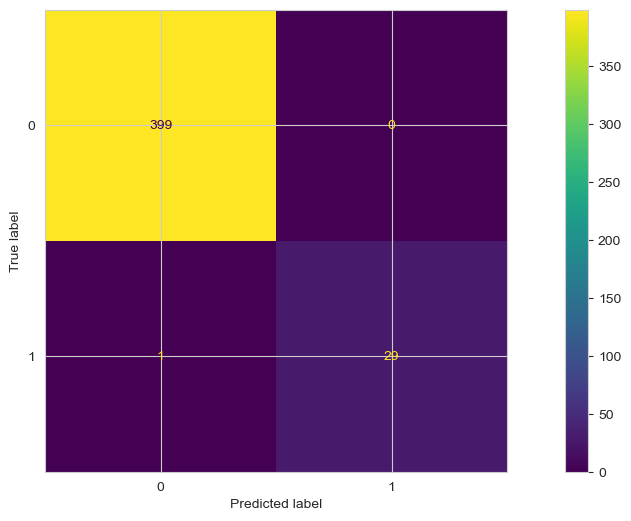

In [204]:
cm=confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [205]:
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test,y_pred)
print(precision)
print(recall)

1.0
0.9666666666666667


## ROC curve

No Skill: ROC AUC=0.500
Random_forest: ROC AUC=0.994


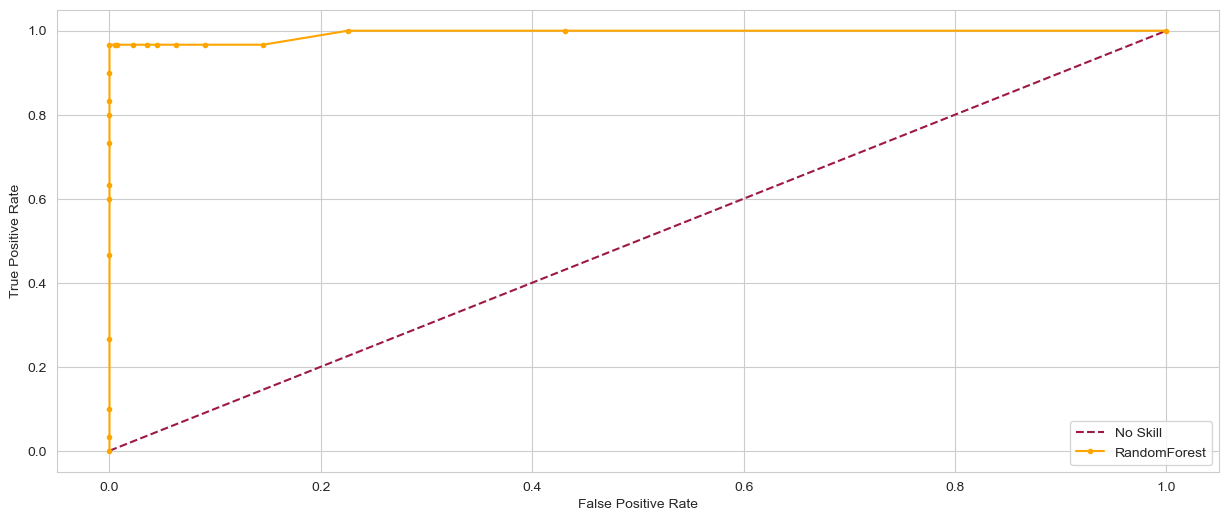

In [206]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# keep probabilities for the positive outcome only
rf_probs1 = rf_probs[:,1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
RandomForest_auc = roc_auc_score(y_test, rf_probs1)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random_forest: ROC AUC=%.3f' % (RandomForest_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs1)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='RandomForest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

* The Model Achieved a 99% accuarcy, with a recall rate of 96%. This means that the model was able to correctly identify true fraudulent transactions at an accuracy rate of 96%. The ROC_AUC was 99%, indicating that the model achieved a high score in terms of differentiating the two classes (fraudulent and non-fraudulent transactions).

## Insights and Recommendations:

 * Analysis shows some transaction channels may be more prone to fraudulent activities compared to others. i.e channels like paypal and credit card had a high number of transactions that were either refunds or chargebacks. The business should invest more effort in identifying types of fraudulent activities in this channels and relevant indicators to reduce risk
 
 
 * Transaction times could be used as an indicator for fraudulent transaction. As seen in the anlaysis, majority of the transactions occuring very late at night or early in the morning appeared suscpicious and also had a large number of transactions (36%) being refunds and chargebacks
 
* A high rate of transaction cancellations or failures, especially for legitimate transactions, can be a sign of attempted fraud.Business should monitor frequency of cancellations as key ndicators for attempted fraud.

* Unusual Transaction Amounts: Transactions significantly deviating from the typical range of transaction amounts for a given customer or merchant may indicate fraudulent behavior.
 
* Detecting fraudulent activities often requires sophisticated analysis techniques, including machine learning algorithms, anomaly detection, and pattern recognition, to identify suspicious patterns and behavior effectively. Additionally, it's crucial to continuously update and refine fraud detection strategies to adapt to evolving fraud schemes and tactics.